In [1]:
import os
import umap
import torch
import itertools
from core import *
import numpy as np
import pandas as pd
import pickle as pkl
from torch import nn
import os.path as op
from tqdm import tqdm
from time import time
from Bio import SeqIO
from copy import deepcopy
from torch.optim import Adam
from tpot import TPOTRegressor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from capsules.capsules import *
from IPython.display import Image
from qhoptim.pyt import QHM, QHAdam
from matplotlib.lines import Line2D
from torch.autograd import Variable
from matplotlib.patches import Patch
from scipy.stats import spearmanr, pearsonr
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score, recall_score

/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: F

In [2]:
len("TTTCTGAGCATCCCGGGGATCCC")

23

In [3]:
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

In [4]:
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.models import ApproximateGP, ExactGP 
from sklearn.metrics import accuracy_score
from gpytorch.priors import SmoothedBoxPrior
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel, GridInterpolationKernel
from gpytorch.mlls import VariationalELBO, VariationalELBOEmpirical, DeepApproximateMLL
from gpytorch.distributions import MultivariateNormal
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP

In [5]:
np.random.seed(1000)

In [6]:
DATAPATH = "/home/bakirillov/HDD/data/genomes/all_guides_chr22.tsv"
ANNOTATION = "/home/bakirillov/HDD/data/genomes/annotation.csv"

In [7]:
annotation = pd.read_csv(ANNOTATION, header=1)[["Start", "Stop", "Gene symbol"]]
annotation = list(
    zip(
        annotation["Start"].values, annotation["Stop"].values, 
        annotation["Gene symbol"].values
    )
)
annotation = sorted(annotation, key=lambda x: x[0])

In [8]:
transformer = get_Cas9_transformer(True)

In [9]:
chr22 = SeqIO.parse("/home/bakirillov/HDD/data/genomes/chr22.fa", "fasta")
chr22 = [a for a in chr22][0]

In [10]:
TEMPLATE = "/home/bakirillov/HDD/data/chr22_genes/GENE\nPERFECTMATCH\nNNNNNNNNNNNNNNNNNNNNNGG 6\n"
COMMAND = "/home/bakirillov/HDD/apps/cas-offinder CONFIG G OUTPUT"

In [11]:
%%bash

ls | grep xls

Cpf1_table.xlsx
ST3.xlsx
ST4 Chr22 top gRNAs per gene.xlsx
W_table.xlsx


In [12]:
d = pd.read_excel("ST4 Chr22 top gRNAs per gene.xlsx", sheet_name=0)

In [13]:
TOP10 = np.random.choice(d["4"].unique(), 1000, replace=False)

In [15]:
script = open("run_casoffinder_ot.sh", "w")
script.write("#!/bin/sh\n\n")
for start, stop, gene in tqdm(annotation):
    with open("/home/bakirillov/HDD/data/chr22_genes_OT/"+gene+".fa", "w") as oh:
        oh.write(">"+gene+"\n")
        oh.write(str(chr22.seq[start:stop]))
    with open("/home/bakirillov/HDD/data/chr22_casoffinder_configs_OT/"+gene+".txt", "w") as oh:
        oh.write(TEMPLATE.replace("GENE", gene+".fa").split("\n")[0])
        oh.write("\nNNNNNNNNNNNNNNNNNNNNNGG\n")
        for a in TOP10:
            for b in range(1, 7):
                oh.write(a+" "+str(b)+"\n")
    script.write(
        COMMAND.replace(
            "CONFIG", "/home/bakirillov/HDD/data/chr22_casoffinder_configs_OT/"+gene+".txt"
        ).replace(
            "OUTPUT", "/home/bakirillov/HDD/data/chr22_grnas_OT/"+gene+".tsv"
        )+"\n"
    )
script.close()

100%|██████████| 1186/1186 [00:04<00:00, 278.96it/s]


In [16]:
data = np.array(
    [a for a in os.walk("/home/bakirillov/HDD/data/chr22_grnas_OT/")][0][2]
)

In [17]:
sizes = np.array(
    [op.getsize(op.join("/home/bakirillov/HDD/data/chr22_grnas_OT", a)) for a in data]
)

In [18]:
u = ImperfectMatchTransform("NGG", False, False, fold=False, cut_at_start=0, cut_at_end=0)
transformer = transforms.Compose(
    [
        u, ToTensor(cudap=True)
    ]
)

In [19]:
w_encoder = GuideHN2d(
    23, capsule_dimension=32, n_routes=1600, n_classes=5, n_channels=2,
).cuda()
w_model = DKL(w_encoder, [1,5*32]).cuda().eval()
w_model.load_state_dict(torch.load("../models/Weissman/cnn59.ptch"))
w_model = w_model.eval()

In [20]:
genes = {a[2]: [] for a in annotation}
for i,a in enumerate(data):
    #with open(op.join("/home/bakirillov/HDD/data/casoffinder_data/", a), "r"):
    try:
        current_df = pd.read_csv(
            op.join(
                "/home/bakirillov/HDD/data/chr22_grnas_OT/"+a
            ), sep="\t", header=None
        ).dropna()
        current_df = current_df[current_df[3].apply(lambda x: len(x) == 23 and " " not in x)]
        current_df[6] = [a]*current_df.shape[0]
        print(i, current_df.shape)
    except Exception as e:
        print(e)
    else:
        tds = WeissmanDataset(
            current_df, np.arange(current_df.shape[0]), transformer,
            genome_column=3, sgRNA_column=0,
            label_column=5
        )
        tld = DataLoader(tds, shuffle=False, batch_size=256)
        tb_w_oa = []
        tb_w_va = []
        tb_w_ra = []
        for transformed_batch, _ in tqdm(tld):
            tb_w_o = w_encoder(transformed_batch)[0].cpu().data.numpy()
            tb_w_ra.extend(tb_w_o)
            tb_w = w_model(transformed_batch)
            tb_w_o = w_model.likelihood(
                tb_w[0]
            ).mean.mean(0).cpu().data.numpy()
            tb_w_v = w_model.likelihood(
                tb_w[0]
            ).variance.mean(0).cpu().data.numpy()
            tb_w_oa.extend(tb_w_o)
            tb_w_va.extend(tb_w_v)
        current_df[7] = tb_w_oa
        current_df[8] = tb_w_va
        current_df = current_df.sort_values(by=7, ascending=False)
        current_df.to_csv(
            op.join(
                "/home/bakirillov/HDD/data/cas9_ot_ordered/"+a
            ), sep="\t", header=None
        )

 50%|█████     | 1/2 [00:00<00:00,  7.12it/s]

0 (502, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.11it/s]

1 (14, 7)
No columns to parse from file
3 (309, 7)


 14%|█▍        | 1/7 [00:00<00:00,  6.90it/s]

4 (16, 7)
5 (1589, 7)


 12%|█▎        | 1/8 [00:00<00:00,  7.18it/s]

6 (15, 7)
7 (1873, 7)


  6%|▌         | 1/18 [00:00<00:02,  7.34it/s]

8 (4557, 7)


  5%|▍         | 1/22 [00:00<00:03,  6.72it/s]

9 (5380, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.47it/s]

10 (450, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

No columns to parse from file
12 (149, 7)
13 (32, 7)
14 (187, 7)


 10%|█         | 1/10 [00:00<00:01,  6.36it/s]

15 (2422, 7)


  0%|          | 0/21 [00:00<?, ?it/s]

16 (8, 7)
17 (44, 7)
18 (108, 7)
19 (5140, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

20 (10, 7)
21 (154, 7)
22 (680, 7)


100%|██████████| 3/3 [00:00<00:00,  7.23it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/6 [00:00<?, ?it/s]

23 (12, 7)
24 (217, 7)
25 (1428, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.98it/s]

26 (19, 7)
27 (466, 7)


  0%|          | 0/15 [00:00<?, ?it/s]

28 (7, 7)
29 (76, 7)
30 (3732, 7)


  3%|▎         | 1/34 [00:00<00:04,  7.11it/s]

31 (8655, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.90it/s]

32 (573, 7)


 14%|█▍        | 1/7 [00:00<00:00,  7.42it/s]

33 (1765, 7)


  6%|▌         | 1/18 [00:00<00:02,  7.26it/s]

34 (12, 7)
35 (4548, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.36it/s]

36 (608, 7)


  0%|          | 0/9 [00:00<?, ?it/s]

37 (41, 7)
38 (202, 7)
39 (2105, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

40 (160, 7)
41 (8, 7)
42 (75, 7)
43 (163, 7)


  0%|          | 0/6 [00:00<?, ?it/s]

44 (169, 7)
45 (119, 7)
46 (1487, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.52it/s]

47 (23, 7)
48 (421, 7)


 25%|██▌       | 1/4 [00:00<00:00,  7.66it/s]

49 (918, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.51it/s]

50 (639, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

No columns to parse from file
52 (115, 7)
53 (30, 7)
54 (15, 7)
55 (30, 7)
56 (310, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.38it/s]

57 (655, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

58 (5, 7)
59 (60, 7)
No columns to parse from file
61 (19, 7)
62 (1544, 7)


  0%|          | 0/11 [00:00<?, ?it/s]

63 (89, 7)
64 (1, 7)
65 (2756, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

66 (31, 7)
67 (23, 7)
68 (36, 7)
69 (128, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.75it/s]

70 (803, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.59it/s]

71 (831, 7)


 25%|██▌       | 1/4 [00:00<00:00,  7.60it/s]

72 (15, 7)
73 (782, 7)


 14%|█▍        | 1/7 [00:00<00:00,  7.51it/s]

74 (1694, 7)


 14%|█▍        | 1/7 [00:00<00:00,  7.46it/s]

75 (1792, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.68it/s]

76 (626, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

77 (41, 7)
78 (12, 7)
79 (15, 7)
80 (888, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

81 (42, 7)
82 (11, 7)
83 (344, 7)


 25%|██▌       | 1/4 [00:00<00:00,  7.50it/s]

84 (13, 7)
85 (987, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

86 (34, 7)
87 (14, 7)
88 (186, 7)
89 (143, 7)


 25%|██▌       | 1/4 [00:00<00:00,  7.17it/s]

90 (922, 7)


 25%|██▌       | 1/4 [00:00<00:00,  7.23it/s]

91 (16, 7)
92 (969, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.03it/s]

93 (518, 7)


 20%|██        | 1/5 [00:00<00:00,  7.20it/s]

94 (1255, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

95 (13, 7)
96 (149, 7)
97 (143, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

98 (306, 7)
99 (47, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

100 (163, 7)
101 (14, 7)
102 (913, 7)


  6%|▌         | 1/18 [00:00<00:02,  7.58it/s]

103 (4411, 7)


  9%|▉         | 1/11 [00:00<00:01,  7.51it/s]

104 (2584, 7)


  0%|          | 0/8 [00:00<?, ?it/s]

105 (36, 7)
106 (1950, 7)


100%|██████████| 8/8 [00:01<00:00,  6.21it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
 33%|███▎      | 1/3 [00:00<00:00,  6.61it/s]

107 (6, 7)
108 (751, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

109 (196, 7)
110 (558, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

111 (20, 7)
112 (90, 7)
113 (806, 7)


100%|██████████| 1/1 [00:00<00:00, 36.29it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/36 [00:00<?, ?it/s]

114 (21, 7)
115 (49, 7)
116 (34, 7)
117 (6, 7)
No columns to parse from file
119 (1, 7)
120 (15, 7)
121 (9148, 7)


 17%|█▋        | 1/6 [00:00<00:00,  7.00it/s]

No columns to parse from file
123 (1400, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.12it/s]

124 (674, 7)


  0%|          | 0/13 [00:00<?, ?it/s]

125 (105, 7)
126 (3235, 7)


 25%|██▌       | 1/4 [00:00<00:00,  7.55it/s]

127 (934, 7)


 17%|█▋        | 1/6 [00:00<00:00,  7.57it/s]

128 (33, 7)
129 (1339, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

130 (288, 7)
131 (551, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

132 (308, 7)
133 (41, 7)


 14%|█▍        | 1/7 [00:00<00:00,  7.69it/s]

134 (1599, 7)


  3%|▎         | 1/38 [00:00<00:05,  7.23it/s]

135 (9548, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.99it/s]

136 (663, 7)


  8%|▊         | 1/12 [00:00<00:01,  7.55it/s]

137 (2988, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

138 (146, 7)
139 (32, 7)
140 (11, 7)
141 (768, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

142 (70, 7)
No columns to parse from file
144 (34, 7)
145 (87, 7)
146 (14, 7)
147 (3, 7)
148 (21, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.95it/s]

149 (12, 7)
150 (806, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

151 (46, 7)
152 (32, 7)
153 (90, 7)
154 (35, 7)
155 (529, 7)


100%|██████████| 2/2 [00:00<00:00, 10.72it/s]


156 (338, 7)
157 (1384, 7)


  0%|          | 0/12 [00:00<?, ?it/s]

158 (278, 7)
159 (2859, 7)


  8%|▊         | 1/12 [00:00<00:01,  7.46it/s]

160 (2904, 7)


100%|██████████| 1/1 [00:00<00:00,  8.92it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/1 [00:00<?, ?it/s]

161 (199, 7)
162 (6, 7)
163 (193, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.01it/s]

164 (359, 7)


  0%|          | 0/13 [00:00<?, ?it/s]

165 (81, 7)
166 (3074, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

167 (128, 7)
168 (891, 7)


100%|██████████| 1/1 [00:00<00:00, 14.50it/s]

169 (129, 7)
170 (57, 7)
171 (119, 7)



  2%|▏         | 1/58 [00:00<00:07,  7.45it/s]

172 (14670, 7)


100%|██████████| 2/2 [00:00<00:00, 10.82it/s]

173 (309, 7)
174 (1, 7)



 50%|█████     | 1/2 [00:00<00:00,  7.05it/s]

175 (373, 7)


 10%|█         | 1/10 [00:00<00:01,  7.52it/s]

176 (2550, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.25it/s]

177 (673, 7)


  0%|          | 0/6 [00:00<?, ?it/s]

178 (56, 7)
179 (36, 7)
180 (21, 7)
181 (1533, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.42it/s]

182 (749, 7)


100%|██████████| 3/3 [00:00<00:00,  7.37it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
 17%|█▋        | 1/6 [00:00<00:00,  6.59it/s]

183 (6, 7)
184 (1311, 7)


 25%|██▌       | 1/4 [00:00<00:00,  7.32it/s]

185 (852, 7)


  8%|▊         | 1/13 [00:00<00:01,  7.42it/s]

186 (3196, 7)


  4%|▍         | 1/24 [00:00<00:03,  7.01it/s]

187 (5918, 7)


 20%|██        | 1/5 [00:00<00:00,  7.37it/s]

188 (54, 7)
189 (1096, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

190 (178, 7)
191 (22, 7)
192 (444, 7)


  3%|▎         | 1/29 [00:00<00:04,  6.96it/s]

193 (7398, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.38it/s]

194 (615, 7)


100%|██████████| 2/2 [00:00<00:00, 10.61it/s]

195 (337, 7)
196 (77, 7)



  0%|          | 0/1 [00:00<?, ?it/s]

197 (150, 7)
198 (187, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.99it/s]

199 (505, 7)


  5%|▌         | 1/20 [00:00<00:02,  7.13it/s]

200 (14, 7)
201 (5108, 7)


  2%|▏         | 1/56 [00:00<00:07,  6.93it/s]

202 (11, 7)
No columns to parse from file
204 (14316, 7)


  4%|▍         | 1/23 [00:00<00:03,  6.52it/s]

205 (5697, 7)


  5%|▌         | 1/19 [00:00<00:02,  7.02it/s]

206 (10, 7)
207 (4852, 7)


  8%|▊         | 1/13 [00:00<00:01,  7.39it/s]

208 (3230, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

209 (165, 7)
No columns to parse from file
211 (390, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

212 (186, 7)
213 (26, 7)
214 (25, 7)
215 (92, 7)


  0%|          | 0/17 [00:00<?, ?it/s]

216 (91, 7)
217 (16, 7)
218 (4197, 7)


  4%|▍         | 1/23 [00:00<00:03,  7.05it/s]

219 (57, 7)
220 (5668, 7)


  0%|          | 0/20 [00:00<?, ?it/s]

221 (29, 7)
222 (14, 7)
223 (12, 7)
224 (5099, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.07it/s]

225 (485, 7)


  6%|▌         | 1/17 [00:00<00:02,  7.47it/s]

226 (3, 7)
227 (4176, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.80it/s]

228 (970, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

No columns to parse from file
230 (125, 7)
231 (76, 7)
232 (1732, 7)


100%|██████████| 7/7 [00:01<00:00,  6.89it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
 10%|█         | 1/10 [00:00<00:01,  6.96it/s]

233 (6, 7)
234 (2349, 7)


  8%|▊         | 1/13 [00:00<00:01,  7.35it/s]

235 (29, 7)
236 (3136, 7)


  0%|          | 0/14 [00:00<?, ?it/s]

237 (15, 7)
238 (13, 7)
239 (21, 7)
240 (2, 7)
241 (3332, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.28it/s]

242 (4, 7)
243 (323, 7)


 25%|██▌       | 1/4 [00:00<00:00,  7.40it/s]

244 (883, 7)


  0%|          | 0/6 [00:00<?, ?it/s]

245 (1, 7)
246 (171, 7)
247 (1400, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

248 (108, 7)
249 (106, 7)
250 (13, 7)
251 (36, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

252 (656, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

253 (163, 7)
254 (61, 7)
No columns to parse from file
No columns to parse from file
257 (140, 7)


  3%|▎         | 1/37 [00:00<00:04,  7.35it/s]

258 (9404, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.06it/s]

259 (961, 7)


  5%|▌         | 1/19 [00:00<00:02,  6.59it/s]

260 (4857, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.82it/s]

261 (18, 7)
262 (1432, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

263 (65, 7)
264 (35, 7)
265 (339, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.21it/s]

266 (614, 7)


100%|██████████| 1/1 [00:00<00:00, 48.50it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/3 [00:00<?, ?it/s]

267 (13, 7)
268 (6, 7)
269 (15, 7)
270 (639, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.30it/s]

271 (444, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.25it/s]

272 (729, 7)


 20%|██        | 1/5 [00:00<00:00,  7.13it/s]

273 (14, 7)
274 (17, 7)
275 (1060, 7)


100%|██████████| 2/2 [00:00<00:00, 12.36it/s]

276 (13, 7)
277 (274, 7)
278 (13, 7)



  2%|▏         | 1/50 [00:00<00:06,  7.07it/s]

279 (12706, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

280 (91, 7)
281 (1004, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

282 (324, 7)
283 (20, 7)


  0%|          | 0/11 [00:00<?, ?it/s]

284 (15, 7)
285 (18, 7)
286 (2600, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

287 (32, 7)
288 (46, 7)
289 (45, 7)
290 (14, 7)
No columns to parse from file
292 (4, 7)
293 (5, 7)
294 (17, 7)


  0%|          | 0/16 [00:00<?, ?it/s]

295 (65, 7)
296 (9, 7)
297 (3865, 7)


 12%|█▎        | 1/8 [00:00<00:01,  6.98it/s]

298 (1802, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

299 (125, 7)
300 (1716, 7)


  3%|▎         | 1/34 [00:00<00:04,  7.50it/s]

301 (8657, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.63it/s]

302 (9, 7)
No columns to parse from file
304 (548, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

305 (4, 7)
306 (17, 7)
307 (18, 7)
308 (19, 7)
309 (17, 7)
310 (15, 7)
311 (346, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.59it/s]

312 (16, 7)
313 (267, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]

314 (346, 7)


  7%|▋         | 1/14 [00:00<00:01,  6.65it/s]

315 (3431, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

316 (138, 7)
317 (911, 7)


  0%|          | 0/12 [00:00<?, ?it/s]

318 (96, 7)
319 (15, 7)
320 (2875, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

321 (88, 7)
322 (30, 7)
323 (1105, 7)


 25%|██▌       | 1/4 [00:00<00:00,  7.40it/s]

324 (21, 7)
325 (899, 7)


 20%|██        | 1/5 [00:00<00:00,  7.33it/s]

326 (1235, 7)


  7%|▋         | 1/15 [00:00<00:01,  7.28it/s]

327 (33, 7)
328 (3757, 7)


100%|██████████| 15/15 [00:02<00:00,  7.46it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/11 [00:00<?, ?it/s]

329 (6, 7)
330 (29, 7)
331 (96, 7)
332 (19, 7)
333 (2702, 7)


  7%|▋         | 1/15 [00:00<00:01,  7.10it/s]

334 (7, 7)
335 (3627, 7)


  2%|▏         | 1/66 [00:00<00:09,  6.72it/s]

336 (16646, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

337 (305, 7)
338 (59, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.40it/s]

339 (2, 7)
340 (16, 7)
341 (304, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

342 (16, 7)
343 (44, 7)
344 (1, 7)
345 (1752, 7)


  0%|          | 0/8 [00:00<?, ?it/s]

346 (61, 7)
347 (105, 7)
348 (1803, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.10it/s]

349 (429, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.41it/s]

350 (70, 7)
351 (275, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.35it/s]

352 (25, 7)
353 (620, 7)


  6%|▋         | 1/16 [00:00<00:02,  7.35it/s]

354 (4077, 7)


  0%|          | 0/19 [00:00<?, ?it/s]

355 (7, 7)
356 (22, 7)
357 (10, 7)
358 (8, 7)
359 (15, 7)
360 (4631, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.01it/s]

361 (21, 7)
362 (345, 7)


 20%|██        | 1/5 [00:00<00:00,  7.09it/s]

363 (1154, 7)


100%|██████████| 2/2 [00:00<00:00, 10.45it/s]

364 (354, 7)



  6%|▋         | 1/16 [00:00<00:01,  7.57it/s]

365 (3915, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

366 (68, 7)
367 (12, 7)
368 (269, 7)


  6%|▋         | 1/16 [00:00<00:02,  7.02it/s]

369 (4006, 7)


 17%|█▋        | 1/6 [00:00<00:00,  7.42it/s]

370 (1321, 7)


  4%|▍         | 1/26 [00:00<00:03,  7.47it/s]

371 (6581, 7)


 14%|█▍        | 1/7 [00:00<00:00,  7.42it/s]

372 (1557, 7)


 20%|██        | 1/5 [00:00<00:00,  7.38it/s]

373 (1081, 7)


 25%|██▌       | 1/4 [00:00<00:00,  7.31it/s]

374 (18, 7)
375 (16, 7)
376 (981, 7)


  2%|▏         | 1/45 [00:00<00:06,  7.06it/s]

377 (11364, 7)


 20%|██        | 1/5 [00:00<00:00,  6.79it/s]

378 (1252, 7)


 25%|██▌       | 1/4 [00:00<00:00,  7.23it/s]

379 (21, 7)
380 (881, 7)


  3%|▎         | 1/34 [00:00<00:04,  7.27it/s]

381 (8568, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

382 (50, 7)
383 (61, 7)
384 (1028, 7)


100%|██████████| 1/1 [00:00<00:00, 30.49it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/1 [00:00<?, ?it/s]

385 (37, 7)
386 (6, 7)
387 (12, 7)
388 (250, 7)


100%|██████████| 1/1 [00:00<00:00,  6.94it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/2 [00:00<?, ?it/s]

389 (6, 7)
390 (47, 7)
No columns to parse from file
392 (31, 7)
393 (286, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

394 (91, 7)
395 (261, 7)


  0%|          | 0/13 [00:00<?, ?it/s]

396 (12, 7)
397 (73, 7)
398 (3, 7)
399 (3239, 7)


  2%|▏         | 1/50 [00:00<00:06,  7.51it/s]

400 (12587, 7)


100%|██████████| 50/50 [00:06<00:00,  7.43it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
 12%|█▎        | 1/8 [00:00<00:00,  7.18it/s]

401 (6, 7)
402 (1849, 7)


100%|██████████| 1/1 [00:00<00:00, 65.26it/s]

403 (293, 7)
404 (5, 7)



100%|██████████| 1/1 [00:00<00:00, 32.14it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/2 [00:00<?, ?it/s]

405 (40, 7)
406 (6, 7)
407 (83, 7)
408 (451, 7)


 14%|█▍        | 1/7 [00:00<00:00,  7.37it/s]

409 (1626, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.47it/s]

410 (556, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

411 (280, 7)
No columns to parse from file
413 (132, 7)


100%|██████████| 2/2 [00:00<00:00, 12.18it/s]

414 (21, 7)
415 (292, 7)



  0%|          | 0/4 [00:00<?, ?it/s]

416 (27, 7)
417 (32, 7)
418 (910, 7)


  0%|          | 0/15 [00:00<?, ?it/s]

419 (216, 7)
420 (6, 7)
421 (19, 7)
422 (3742, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

423 (61, 7)
424 (320, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.65it/s]

425 (427, 7)


100%|██████████| 2/2 [00:00<00:00,  7.80it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
 50%|█████     | 1/2 [00:00<00:00,  6.94it/s]

426 (6, 7)
427 (408, 7)


 20%|██        | 1/5 [00:00<00:00,  7.03it/s]

428 (35, 7)
429 (1247, 7)


  6%|▋         | 1/16 [00:00<00:02,  6.77it/s]

430 (8, 7)
431 (4011, 7)


 14%|█▍        | 1/7 [00:00<00:00,  6.23it/s]

432 (1597, 7)


  9%|▉         | 1/11 [00:00<00:01,  6.90it/s]

433 (2760, 7)


  7%|▋         | 1/15 [00:00<00:02,  6.88it/s]

434 (3616, 7)


 10%|█         | 1/10 [00:00<00:01,  6.16it/s]

435 (2400, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.98it/s]

436 (33, 7)
437 (688, 7)


100%|██████████| 1/1 [00:00<00:00,  7.84it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/1 [00:00<?, ?it/s]

438 (19, 7)
439 (226, 7)
440 (12, 7)
441 (29, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.28it/s]

No columns to parse from file
443 (11, 7)
444 (355, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.29it/s]

445 (13, 7)
446 (767, 7)


100%|██████████| 2/2 [00:00<00:00, 10.19it/s]

447 (315, 7)



/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  7%|▋         | 1/15 [00:00<00:01,  7.09it/s]

448 (6, 7)
449 (3617, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.16it/s]

450 (9, 7)
451 (404, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

452 (169, 7)
453 (1219, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

No columns to parse from file
455 (296, 7)
456 (241, 7)


100%|██████████| 1/1 [00:00<00:00, 57.35it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/22 [00:00<?, ?it/s]

457 (34, 7)
458 (10, 7)
459 (12, 7)
460 (5486, 7)


  5%|▍         | 1/22 [00:00<00:02,  7.02it/s]

461 (31, 7)
462 (5552, 7)


  0%|          | 0/10 [00:00<?, ?it/s]

463 (17, 7)
464 (69, 7)
465 (2426, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

466 (328, 7)
467 (452, 7)


100%|██████████| 2/2 [00:00<00:00,  8.18it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
 33%|███▎      | 1/3 [00:00<00:00,  7.31it/s]

468 (6, 7)
469 (9, 7)
470 (556, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.49it/s]

471 (405, 7)


 20%|██        | 1/5 [00:00<00:00,  7.40it/s]

472 (51, 7)
473 (1104, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.63it/s]

474 (2, 7)
475 (425, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

476 (115, 7)
477 (4, 7)
478 (14, 7)
479 (801, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.12it/s]

No columns to parse from file
481 (28, 7)
482 (364, 7)


 11%|█         | 1/9 [00:00<00:01,  7.05it/s]

483 (2131, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.98it/s]

484 (8, 7)
485 (758, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.92it/s]

486 (1296, 7)


  0%|          | 0/16 [00:00<?, ?it/s]

487 (67, 7)
488 (3860, 7)


 14%|█▍        | 1/7 [00:00<00:00,  7.04it/s]

489 (1777, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

490 (105, 7)
491 (1, 7)
492 (36, 7)
493 (239, 7)


100%|██████████| 1/1 [00:00<00:00, 23.14it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/3 [00:00<?, ?it/s]

494 (19, 7)
495 (28, 7)
496 (11, 7)
497 (63, 7)
498 (6, 7)
499 (684, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.04it/s]

500 (373, 7)


 14%|█▍        | 1/7 [00:00<00:00,  7.09it/s]

501 (1686, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.80it/s]

502 (717, 7)


100%|██████████| 1/1 [00:00<00:00, 64.03it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/8 [00:00<?, ?it/s]

503 (61, 7)
No columns to parse from file
505 (7, 7)
506 (18, 7)
507 (1919, 7)


 20%|██        | 1/5 [00:00<00:00,  7.18it/s]

508 (1057, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.01it/s]

509 (463, 7)


  7%|▋         | 1/14 [00:00<00:01,  7.02it/s]

510 (9, 7)
511 (3491, 7)


  0%|          | 0/6 [00:00<?, ?it/s]

512 (52, 7)
513 (192, 7)
514 (1410, 7)


 17%|█▋        | 1/6 [00:00<00:00,  7.58it/s]

515 (53, 7)
516 (1531, 7)


  1%|▏         | 1/73 [00:00<00:09,  7.46it/s]

517 (18654, 7)


  6%|▌         | 1/18 [00:00<00:02,  7.58it/s]

518 (4544, 7)


  9%|▉         | 1/11 [00:00<00:01,  7.65it/s]

519 (2758, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

520 (15, 7)
521 (45, 7)
522 (59, 7)
523 (805, 7)


100%|██████████| 1/1 [00:00<00:00, 45.26it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/2 [00:00<?, ?it/s]

524 (19, 7)
525 (6, 7)
526 (78, 7)
527 (40, 7)
528 (469, 7)


  8%|▊         | 1/13 [00:00<00:01,  7.11it/s]

529 (3212, 7)


100%|██████████| 13/13 [00:01<00:00,  7.28it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
100%|██████████| 1/1 [00:00<00:00, 27.37it/s]

530 (6, 7)
531 (138, 7)
532 (46, 7)
533 (52, 7)
534 (13, 7)



100%|██████████| 1/1 [00:00<00:00, 19.80it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/4 [00:00<?, ?it/s]

535 (18, 7)
536 (76, 7)
537 (6, 7)
538 (941, 7)


  5%|▌         | 1/20 [00:00<00:02,  7.02it/s]

539 (5060, 7)


100%|██████████| 1/1 [00:00<00:00, 78.57it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
100%|██████████| 1/1 [00:00<00:00, 26.09it/s]

540 (13, 7)
541 (3, 7)
542 (5, 7)
543 (3, 7)
544 (18, 7)
545 (30, 7)
546 (55, 7)



100%|██████████| 1/1 [00:00<00:00, 27.57it/s]

547 (11, 7)
548 (214, 7)
549 (49, 7)



 33%|███▎      | 1/3 [00:00<00:00,  6.98it/s]

550 (521, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

551 (74, 7)
552 (28, 7)
553 (126, 7)
554 (13, 7)
555 (83, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.41it/s]

556 (472, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.25it/s]

557 (458, 7)


 20%|██        | 1/5 [00:00<00:00,  7.24it/s]

558 (1109, 7)


100%|██████████| 1/1 [00:00<00:00,  7.80it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
100%|██████████| 1/1 [00:00<00:00, 63.70it/s]

559 (32, 7)
560 (235, 7)
561 (6, 7)
562 (15, 7)



  1%|          | 1/94 [00:00<00:12,  7.20it/s]

563 (23950, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

564 (297, 7)
565 (173, 7)


  9%|▉         | 1/11 [00:00<00:01,  7.71it/s]

566 (8, 7)
567 (2630, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.50it/s]

568 (713, 7)


  3%|▎         | 1/36 [00:00<00:04,  7.47it/s]

569 (9135, 7)


  6%|▋         | 1/16 [00:00<00:02,  7.10it/s]

570 (3846, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.13it/s]

571 (533, 7)


  5%|▍         | 1/22 [00:00<00:02,  7.11it/s]

572 (5419, 7)


 25%|██▌       | 1/4 [00:00<00:00,  7.21it/s]

573 (976, 7)


 25%|██▌       | 1/4 [00:00<00:00,  7.26it/s]

574 (841, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

575 (89, 7)
576 (15, 7)
577 (1177, 7)


 10%|█         | 1/10 [00:00<00:01,  7.63it/s]

578 (2385, 7)


 25%|██▌       | 1/4 [00:00<00:00,  7.47it/s]

579 (8, 7)
580 (25, 7)
581 (953, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

582 (48, 7)
583 (52, 7)
584 (33, 7)
585 (839, 7)


  6%|▋         | 1/16 [00:00<00:02,  7.32it/s]

586 (26, 7)
587 (3969, 7)


 17%|█▋        | 1/6 [00:00<00:00,  7.07it/s]

588 (51, 7)
589 (1454, 7)


  7%|▋         | 1/14 [00:00<00:01,  7.39it/s]

590 (3370, 7)


  8%|▊         | 1/13 [00:00<00:01,  7.42it/s]

591 (3141, 7)


  1%|          | 1/103 [00:00<00:13,  7.33it/s]

592 (26129, 7)


 10%|█         | 1/10 [00:00<00:01,  7.25it/s]

593 (2308, 7)


 11%|█         | 1/9 [00:00<00:01,  7.29it/s]

594 (2192, 7)


  7%|▋         | 1/15 [00:00<00:01,  7.40it/s]

595 (38, 7)
596 (3662, 7)


 25%|██▌       | 1/4 [00:00<00:00,  7.66it/s]

597 (8, 7)
598 (853, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

599 (240, 7)
600 (32, 7)
601 (81, 7)


  0%|          | 0/54 [00:00<?, ?it/s]

602 (106, 7)
603 (63, 7)
604 (13588, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

605 (67, 7)
No columns to parse from file
607 (626, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

608 (86, 7)
609 (333, 7)


 25%|██▌       | 1/4 [00:00<00:00,  7.15it/s]

610 (51, 7)
611 (882, 7)


100%|██████████| 4/4 [00:00<00:00,  7.98it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/4 [00:00<?, ?it/s]

612 (12, 7)
613 (54, 7)
614 (971, 7)


100%|██████████| 1/1 [00:00<00:00, 25.43it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/1 [00:00<?, ?it/s]

615 (33, 7)
616 (14, 7)
617 (53, 7)
618 (12, 7)
619 (36, 7)
620 (159, 7)


 20%|██        | 1/5 [00:00<00:00,  7.31it/s]

621 (1171, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

622 (38, 7)
623 (41, 7)
624 (83, 7)
625 (25, 7)
626 (1131, 7)


  4%|▍         | 1/23 [00:00<00:02,  7.35it/s]

627 (5790, 7)


 14%|█▍        | 1/7 [00:00<00:00,  7.18it/s]

628 (3, 7)
629 (1613, 7)


 12%|█▎        | 1/8 [00:00<00:00,  7.03it/s]

630 (1982, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

631 (182, 7)
632 (124, 7)
633 (55, 7)


 17%|█▋        | 1/6 [00:00<00:00,  7.27it/s]

634 (1498, 7)


 20%|██        | 1/5 [00:00<00:00,  7.21it/s]

635 (1044, 7)


 12%|█▎        | 1/8 [00:00<00:00,  7.14it/s]

636 (1909, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.74it/s]

637 (467, 7)


  0%|          | 0/37 [00:00<?, ?it/s]

638 (11, 7)
639 (25, 7)
640 (4, 7)
641 (32, 7)
642 (9316, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

643 (128, 7)
644 (13, 7)
No columns to parse from file
646 (61, 7)
647 (55, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

No columns to parse from file
649 (133, 7)
650 (9, 7)
651 (420, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

652 (10, 7)
653 (188, 7)
No columns to parse from file
655 (28, 7)
656 (418, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

657 (21, 7)
658 (56, 7)
No columns to parse from file
660 (675, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.14it/s]

661 (2, 7)
662 (478, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.76it/s]

663 (336, 7)


 20%|██        | 1/5 [00:00<00:00,  6.81it/s]

664 (1131, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.61it/s]

665 (578, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

666 (109, 7)
667 (1559, 7)


  6%|▋         | 1/16 [00:00<00:01,  7.83it/s]

668 (3868, 7)


 17%|█▋        | 1/6 [00:00<00:00,  7.74it/s]

669 (15, 7)
670 (1396, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.67it/s]

671 (573, 7)


  4%|▍         | 1/24 [00:00<00:02,  7.67it/s]

672 (5905, 7)


  4%|▍         | 1/25 [00:00<00:03,  7.00it/s]

673 (6366, 7)


 17%|█▋        | 1/6 [00:00<00:00,  7.13it/s]

674 (1458, 7)


 12%|█▎        | 1/8 [00:00<00:00,  7.40it/s]

675 (1900, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.99it/s]

676 (1428, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.28it/s]

677 (480, 7)


  7%|▋         | 1/14 [00:00<00:01,  7.36it/s]

678 (3527, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.59it/s]

679 (16, 7)
680 (1291, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.62it/s]

681 (800, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.61it/s]

682 (503, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

683 (232, 7)
684 (11, 7)
685 (453, 7)


  9%|▉         | 1/11 [00:00<00:01,  7.16it/s]

686 (2802, 7)


 11%|█         | 1/9 [00:00<00:01,  7.12it/s]

687 (2144, 7)


100%|██████████| 2/2 [00:00<00:00, 10.21it/s]

688 (348, 7)



  0%|          | 0/2 [00:00<?, ?it/s]

689 (82, 7)
690 (1, 7)
691 (494, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

692 (245, 7)
693 (98, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

694 (228, 7)
695 (3, 7)
696 (50, 7)
697 (18, 7)


  8%|▊         | 1/12 [00:00<00:01,  7.52it/s]

698 (2851, 7)


100%|██████████| 1/1 [00:00<00:00, 78.73it/s]

699 (302, 7)
700 (2, 7)



/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/4 [00:00<?, ?it/s]

701 (6, 7)
No columns to parse from file
703 (54, 7)
704 (15, 7)
705 (861, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.22it/s]

706 (559, 7)


  3%|▎         | 1/36 [00:00<00:04,  7.03it/s]

707 (9010, 7)


100%|██████████| 36/36 [00:04<00:00,  7.29it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
 50%|█████     | 1/2 [00:00<00:00,  7.09it/s]

708 (12, 7)
709 (460, 7)


100%|██████████| 1/1 [00:00<00:00, 10.46it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/1 [00:00<?, ?it/s]

710 (14, 7)
711 (167, 7)
712 (6, 7)
713 (143, 7)


  8%|▊         | 1/13 [00:00<00:01,  7.05it/s]

714 (3, 7)
715 (9, 7)
716 (3130, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.19it/s]

717 (47, 7)
718 (559, 7)


  0%|          | 0/23 [00:00<?, ?it/s]

719 (47, 7)
720 (27, 7)
721 (5861, 7)


100%|██████████| 23/23 [00:03<00:00,  7.35it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/3 [00:00<?, ?it/s]

722 (12, 7)
723 (67, 7)
724 (29, 7)
725 (540, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.98it/s]

726 (22, 7)
727 (810, 7)


100%|██████████| 2/2 [00:00<00:00, 10.66it/s]


728 (319, 7)
729 (559, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

730 (217, 7)
731 (827, 7)


 11%|█         | 1/9 [00:00<00:01,  7.35it/s]

732 (2181, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.19it/s]

733 (368, 7)


 14%|█▍        | 1/7 [00:00<00:00,  6.73it/s]

734 (1590, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.29it/s]

No columns to parse from file
736 (452, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

737 (19, 7)
738 (73, 7)
739 (63, 7)
740 (11, 7)
741 (96, 7)


  0%|          | 0/15 [00:00<?, ?it/s]

742 (7, 7)
No columns to parse from file
744 (44, 7)
745 (3729, 7)


  0%|          | 0/8 [00:00<?, ?it/s]

746 (132, 7)
747 (45, 7)
748 (1987, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.41it/s]

749 (37, 7)
750 (446, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.38it/s]

751 (55, 7)
752 (564, 7)


 17%|█▋        | 1/6 [00:00<00:00,  7.15it/s]

753 (1482, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.72it/s]

754 (1337, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

755 (8, 7)
756 (8, 7)
757 (21, 7)
758 (487, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

759 (2, 7)
760 (19, 7)
761 (15, 7)
762 (25, 7)
763 (1215, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

764 (221, 7)
765 (18, 7)
766 (653, 7)


 25%|██▌       | 1/4 [00:00<00:00,  7.54it/s]

767 (975, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.54it/s]

768 (428, 7)


  0%|          | 0/12 [00:00<?, ?it/s]

769 (156, 7)
770 (2823, 7)


 11%|█         | 1/9 [00:00<00:01,  7.13it/s]

771 (2183, 7)


  4%|▎         | 1/28 [00:00<00:03,  6.96it/s]

772 (6980, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

773 (35, 7)
774 (40, 7)
775 (199, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.48it/s]

776 (20, 7)
777 (592, 7)


100%|██████████| 3/3 [00:00<00:00,  8.26it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/2 [00:00<?, ?it/s]

778 (12, 7)
779 (15, 7)
780 (386, 7)


  0%|          | 0/10 [00:00<?, ?it/s]

781 (11, 7)
782 (37, 7)
783 (2446, 7)


100%|██████████| 10/10 [00:01<00:00,  7.18it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/5 [00:00<?, ?it/s]

784 (6, 7)
785 (59, 7)
786 (1096, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.80it/s]

787 (773, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.99it/s]

788 (616, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.06it/s]

789 (496, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.82it/s]

790 (903, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.92it/s]

791 (9, 7)
No columns to parse from file
793 (527, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.97it/s]

794 (391, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.95it/s]

795 (365, 7)


  0%|          | 0/6 [00:00<?, ?it/s]

796 (36, 7)
797 (147, 7)
798 (1357, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

799 (30, 7)
800 (126, 7)
801 (684, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.64it/s]

802 (329, 7)


 10%|█         | 1/10 [00:00<00:01,  6.72it/s]

803 (2470, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.41it/s]

804 (573, 7)


 17%|█▋        | 1/6 [00:00<00:00,  7.57it/s]

805 (12, 7)
806 (1292, 7)


  0%|          | 0/34 [00:00<?, ?it/s]

807 (67, 7)
808 (8495, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.75it/s]

809 (5, 7)
810 (839, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.67it/s]

811 (1503, 7)


 25%|██▌       | 1/4 [00:00<00:00,  7.14it/s]

812 (4, 7)
813 (876, 7)


 17%|█▋        | 1/6 [00:00<00:00,  7.09it/s]

814 (1466, 7)


100%|██████████| 1/1 [00:00<00:00, 65.82it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/1 [00:00<?, ?it/s]

815 (21, 7)
816 (211, 7)
817 (8, 7)
818 (12, 7)


100%|██████████| 1/1 [00:00<00:00, 52.74it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/5 [00:00<?, ?it/s]

819 (6, 7)
820 (37, 7)
821 (43, 7)
822 (1236, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

823 (245, 7)
824 (638, 7)


  0%|          | 0/22 [00:00<?, ?it/s]

825 (61, 7)
826 (1, 7)
827 (34, 7)
828 (5469, 7)


 25%|██▌       | 1/4 [00:00<00:00,  7.03it/s]

829 (796, 7)


  7%|▋         | 1/15 [00:00<00:02,  6.93it/s]

830 (3636, 7)


 12%|█▎        | 1/8 [00:00<00:00,  7.08it/s]

831 (1888, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.46it/s]

832 (18, 7)
833 (578, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.39it/s]

834 (744, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

835 (24, 7)
836 (66, 7)
837 (361, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

838 (250, 7)
839 (18, 7)
840 (342, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

841 (85, 7)
842 (1051, 7)


  8%|▊         | 1/13 [00:00<00:01,  7.52it/s]

843 (3325, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.11it/s]

844 (570, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.13it/s]

845 (436, 7)


 10%|█         | 1/10 [00:00<00:01,  7.33it/s]

846 (2306, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

847 (158, 7)
848 (1011, 7)


 17%|█▋        | 1/6 [00:00<00:00,  7.13it/s]

849 (1402, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.25it/s]

850 (613, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

851 (7, 7)
852 (41, 7)
853 (33, 7)
854 (220, 7)


  6%|▋         | 1/16 [00:00<00:02,  7.10it/s]

855 (19, 7)
856 (4066, 7)


 12%|█▎        | 1/8 [00:00<00:01,  6.41it/s]

857 (1961, 7)


100%|██████████| 1/1 [00:00<00:00, 12.40it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/1 [00:00<?, ?it/s]

858 (24, 7)
859 (129, 7)
860 (6, 7)
861 (125, 7)


  0%|          | 0/30 [00:00<?, ?it/s]

862 (57, 7)
863 (69, 7)
864 (7669, 7)


 25%|██▌       | 1/4 [00:00<00:00,  7.85it/s]

865 (11, 7)
866 (934, 7)


  7%|▋         | 1/14 [00:00<00:01,  7.88it/s]

No columns to parse from file
868 (49, 7)
869 (3453, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

No columns to parse from file
871 (186, 7)
872 (68, 7)
873 (1, 7)
874 (455, 7)


100%|██████████| 2/2 [00:00<00:00,  8.41it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/1 [00:00<?, ?it/s]

875 (6, 7)
876 (2, 7)
877 (28, 7)
878 (59, 7)
879 (193, 7)


100%|██████████| 1/1 [00:00<00:00, 15.17it/s]


880 (229, 7)
881 (123, 7)
882 (16, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.32it/s]

883 (28, 7)
884 (588, 7)


 17%|█▋        | 1/6 [00:00<00:00,  7.02it/s]

885 (1334, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.03it/s]

886 (26, 7)
887 (1, 7)
888 (720, 7)


100%|██████████| 1/1 [00:00<00:00, 32.31it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/2 [00:00<?, ?it/s]

889 (12, 7)
890 (44, 7)
891 (6, 7)
892 (273, 7)


 17%|█▋        | 1/6 [00:00<00:00,  7.46it/s]

893 (9, 7)
894 (1466, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

895 (23, 7)
896 (45, 7)
897 (546, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.54it/s]

898 (68, 7)
899 (638, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.46it/s]

900 (479, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

901 (331, 7)
902 (787, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.40it/s]

No columns to parse from file
904 (751, 7)


 14%|█▍        | 1/7 [00:00<00:00,  7.50it/s]

No columns to parse from file
906 (14, 7)
907 (1596, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.46it/s]

908 (57, 7)
909 (357, 7)


100%|██████████| 2/2 [00:00<00:00, 10.46it/s]

910 (356, 7)



 25%|██▌       | 1/4 [00:00<00:00,  7.53it/s]

911 (874, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.50it/s]

912 (516, 7)


 20%|██        | 1/5 [00:00<00:00,  7.50it/s]

913 (1235, 7)


 20%|██        | 1/5 [00:00<00:00,  7.46it/s]

914 (1264, 7)


 14%|█▍        | 1/7 [00:00<00:00,  7.46it/s]

915 (47, 7)
916 (1763, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

917 (233, 7)
918 (53, 7)
919 (35, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

920 (128, 7)
921 (27, 7)
922 (16, 7)
923 (296, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

924 (252, 7)
925 (8, 7)
926 (262, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.44it/s]

927 (27, 7)
928 (486, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

929 (78, 7)
930 (75, 7)
931 (1644, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

932 (13, 7)
933 (227, 7)
934 (710, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

935 (208, 7)
936 (329, 7)


 25%|██▌       | 1/4 [00:00<00:00,  7.45it/s]

937 (968, 7)


100%|██████████| 2/2 [00:00<00:00, 10.47it/s]

938 (352, 7)
No columns to parse from file



100%|██████████| 1/1 [00:00<00:00, 28.37it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/22 [00:00<?, ?it/s]

940 (52, 7)
941 (6, 7)
942 (4, 7)
943 (60, 7)
944 (5421, 7)


 25%|██▌       | 1/4 [00:00<00:00,  8.08it/s]

945 (857, 7)


 12%|█▎        | 1/8 [00:00<00:00,  8.01it/s]

946 (1869, 7)


  0%|          | 0/9 [00:00<?, ?it/s]

947 (37, 7)
948 (38, 7)
949 (2190, 7)


 50%|█████     | 1/2 [00:00<00:00,  8.05it/s]

950 (494, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

951 (84, 7)
952 (36, 7)
953 (44, 7)
954 (518, 7)


  7%|▋         | 1/15 [00:00<00:01,  8.04it/s]

955 (3794, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

956 (13, 7)
957 (202, 7)
958 (11, 7)
959 (1079, 7)


 25%|██▌       | 1/4 [00:00<00:00,  8.03it/s]

960 (873, 7)


  5%|▌         | 1/20 [00:00<00:02,  7.99it/s]

961 (4939, 7)


 25%|██▌       | 1/4 [00:00<00:00,  7.10it/s]

962 (924, 7)


100%|██████████| 2/2 [00:00<00:00, 10.10it/s]

963 (398, 7)



 33%|███▎      | 1/3 [00:00<00:00,  8.08it/s]

964 (697, 7)


 33%|███▎      | 1/3 [00:00<00:00,  8.08it/s]

965 (694, 7)


  0%|          | 0/14 [00:00<?, ?it/s]

966 (108, 7)
967 (9, 7)
968 (3468, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

969 (27, 7)
970 (186, 7)
971 (1679, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

972 (4, 7)
973 (218, 7)
974 (255, 7)


 20%|██        | 1/5 [00:00<00:00,  8.05it/s]

975 (1060, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

976 (155, 7)
977 (550, 7)


  8%|▊         | 1/13 [00:00<00:01,  7.84it/s]

978 (3090, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.47it/s]

979 (9, 7)
980 (624, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.73it/s]

981 (10, 7)
982 (27, 7)
983 (612, 7)


  0%|          | 0/9 [00:00<?, ?it/s]

984 (50, 7)
985 (16, 7)
986 (9, 7)
987 (4, 7)
988 (53, 7)
989 (2177, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

990 (36, 7)
991 (59, 7)
992 (81, 7)
993 (534, 7)


 12%|█▎        | 1/8 [00:00<00:00,  7.50it/s]

994 (20, 7)
995 (1861, 7)


 25%|██▌       | 1/4 [00:00<00:00,  7.45it/s]

996 (922, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.47it/s]

997 (13, 7)
998 (380, 7)


  6%|▋         | 1/16 [00:00<00:02,  7.47it/s]

999 (11, 7)
1000 (3989, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.19it/s]

1001 (432, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.34it/s]

1002 (506, 7)


  0%|          | 0/6 [00:00<?, ?it/s]

1003 (19, 7)
No columns to parse from file
1005 (81, 7)
1006 (1322, 7)


  6%|▋         | 1/16 [00:00<00:02,  7.29it/s]

1007 (5, 7)
1008 (10, 7)
1009 (3870, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

1010 (169, 7)
1011 (548, 7)


 12%|█▎        | 1/8 [00:00<00:00,  7.34it/s]

1012 (1995, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.34it/s]

1013 (58, 7)
1014 (372, 7)


 14%|█▍        | 1/7 [00:00<00:00,  7.43it/s]

1015 (1573, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.12it/s]

1016 (11, 7)
1017 (340, 7)


  7%|▋         | 1/15 [00:00<00:01,  7.32it/s]

1018 (3796, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.30it/s]

1019 (3, 7)
1020 (587, 7)


 17%|█▋        | 1/6 [00:00<00:00,  7.38it/s]

1021 (1311, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

1022 (7, 7)
1023 (100, 7)
1024 (590, 7)


 17%|█▋        | 1/6 [00:00<00:00,  7.37it/s]

1025 (29, 7)
1026 (1411, 7)


 17%|█▋        | 1/6 [00:00<00:00,  7.34it/s]

1027 (1516, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

1028 (128, 7)
1029 (1097, 7)


  0%|          | 0/39 [00:00<?, ?it/s]

1030 (213, 7)
1031 (9934, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.42it/s]

1032 (731, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]

1033 (394, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.48it/s]

1034 (519, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.24it/s]

1035 (593, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1036 (105, 7)
1037 (8, 7)
1038 (112, 7)
1039 (6, 7)


 11%|█         | 1/9 [00:00<00:01,  7.46it/s]

1040 (10, 7)
No columns to parse from file
1042 (2064, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1043 (76, 7)
1044 (27, 7)
1045 (14, 7)
1046 (90, 7)
1047 (27, 7)


  0%|          | 0/10 [00:00<?, ?it/s]

1048 (72, 7)
1049 (32, 7)
1050 (46, 7)
1051 (2461, 7)


100%|██████████| 10/10 [00:01<00:00,  6.85it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  4%|▍         | 1/24 [00:00<00:03,  6.85it/s]

1052 (6, 7)
1053 (6015, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

1054 (129, 7)
1055 (735, 7)


 14%|█▍        | 1/7 [00:00<00:00,  6.98it/s]

1056 (1670, 7)


  0%|          | 0/15 [00:00<?, ?it/s]

1057 (30, 7)
1058 (21, 7)
1059 (15, 7)
1060 (3781, 7)


 14%|█▍        | 1/7 [00:00<00:00,  7.10it/s]

1061 (1561, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

1062 (48, 7)
1063 (12, 7)
1064 (11, 7)
1065 (423, 7)


  5%|▍         | 1/21 [00:00<00:02,  7.31it/s]

1066 (5297, 7)


 20%|██        | 1/5 [00:00<00:00,  7.45it/s]

1067 (1141, 7)


  6%|▋         | 1/16 [00:00<00:01,  7.51it/s]

1068 (3927, 7)


100%|██████████| 1/1 [00:00<00:00, 54.39it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/2 [00:00<?, ?it/s]

1069 (10, 7)
1070 (6, 7)
1071 (131, 7)
1072 (2, 7)
1073 (8, 7)
1074 (269, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

1075 (61, 7)
1076 (1734, 7)


100%|██████████| 1/1 [00:00<00:00, 53.43it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/15 [00:00<?, ?it/s]

1077 (14, 7)
1078 (6, 7)
1079 (38, 7)
1080 (7, 7)
1081 (6, 7)
1082 (3702, 7)


 11%|█         | 1/9 [00:00<00:01,  7.17it/s]

1083 (2205, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.31it/s]

1084 (640, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.44it/s]

1085 (23, 7)
No columns to parse from file
1087 (603, 7)


100%|██████████| 1/1 [00:00<00:00, 39.95it/s]

1088 (264, 7)
1089 (25, 7)



  6%|▋         | 1/16 [00:00<00:02,  7.00it/s]

1090 (3870, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.49it/s]

1091 (691, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.39it/s]

1092 (34, 7)
No columns to parse from file
1094 (441, 7)


  8%|▊         | 1/12 [00:00<00:01,  7.24it/s]

1095 (2924, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

1096 (118, 7)
1097 (444, 7)


100%|██████████| 2/2 [00:00<00:00,  8.10it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/19 [00:00<?, ?it/s]

1098 (18, 7)
1099 (79, 7)
1100 (4638, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.18it/s]

1101 (634, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.26it/s]

1102 (765, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.23it/s]

1103 (550, 7)


100%|██████████| 1/1 [00:00<00:00, 69.59it/s]

1104 (158, 7)
1105 (100, 7)
1106 (4, 7)



  0%|          | 0/16 [00:00<?, ?it/s]

1107 (145, 7)
1108 (4078, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

1109 (33, 7)
1110 (46, 7)
1111 (1743, 7)


  0%|          | 0/10 [00:00<?, ?it/s]

1112 (42, 7)
1113 (94, 7)
1114 (2322, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.43it/s]

1115 (67, 7)
1116 (335, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

1117 (73, 7)
1118 (225, 7)
1119 (790, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1120 (85, 7)
1121 (41, 7)
1122 (134, 7)
1123 (29, 7)


100%|██████████| 1/1 [00:00<00:00, 26.11it/s]
/home/bakirillov/HDD/works/Skoltech/CRISPR_CAD/uace/src/core.py:966: RuntimeWarning: invalid value encountered in true_divide
  self.S[self.label_column]
  0%|          | 0/3 [00:00<?, ?it/s]

1124 (44, 7)
1125 (54, 7)
1126 (6, 7)
1127 (607, 7)


  3%|▎         | 1/29 [00:00<00:03,  7.19it/s]

1128 (7331, 7)


 25%|██▌       | 1/4 [00:00<00:00,  7.35it/s]

1129 (929, 7)


 33%|███▎      | 1/3 [00:00<00:00,  7.32it/s]

1130 (583, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

1131 (168, 7)
1132 (385, 7)


  9%|▉         | 1/11 [00:00<00:01,  7.04it/s]

1133 (2647, 7)


 17%|█▋        | 1/6 [00:00<00:00,  7.29it/s]

1134 (25, 7)
1135 (1317, 7)


  6%|▌         | 1/18 [00:00<00:02,  7.12it/s]

1136 (4607, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

1137 (42, 7)
1138 (156, 7)
1139 (2, 7)
1140 (269, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

1141 (69, 7)
1142 (261, 7)


 17%|█▋        | 1/6 [00:00<00:00,  7.26it/s]

1143 (1346, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

1144 (110, 7)
1145 (47, 7)
1146 (259, 7)


  6%|▌         | 1/18 [00:00<00:02,  7.34it/s]

1147 (4388, 7)


  7%|▋         | 1/14 [00:00<00:01,  7.17it/s]

1148 (3496, 7)


 20%|██        | 1/5 [00:00<00:00,  7.33it/s]

1149 (1251, 7)


  2%|▎         | 1/40 [00:00<00:05,  7.41it/s]

1150 (10202, 7)


  2%|▏         | 1/53 [00:00<00:07,  7.30it/s]

1151 (40, 7)
1152 (13324, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

1153 (219, 7)
1154 (328, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

1155 (11, 7)
1156 (3, 7)
1157 (14, 7)
1158 (683, 7)


 20%|██        | 1/5 [00:00<00:00,  7.39it/s]

1159 (8, 7)
1160 (1214, 7)


  4%|▍         | 1/26 [00:00<00:03,  6.94it/s]

1161 (6625, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1162 (313, 7)
1163 (3, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

1164 (228, 7)
1165 (26, 7)
1166 (2, 7)
1167 (804, 7)


 50%|█████     | 1/2 [00:00<00:00,  7.19it/s]

1168 (353, 7)


100%|██████████| 1/1 [00:00<00:00, 22.68it/s]

1169 (4, 7)
1170 (217, 7)
1171 (65, 7)



  0%|          | 0/5 [00:00<?, ?it/s]

1172 (28, 7)
1173 (1, 7)
1174 (1196, 7)


 12%|█▎        | 1/8 [00:00<00:01,  6.58it/s]

No columns to parse from file
1176 (26, 7)
1177 (1831, 7)


  0%|          | 0/21 [00:00<?, ?it/s]

1178 (86, 7)
1179 (63, 7)
1180 (5362, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

1181 (85, 7)
1182 (14, 7)
1183 (22, 7)
1184 (706, 7)


100%|██████████| 1/1 [00:00<00:00, 21.43it/s]

1185 (65, 7)


In [21]:
ordered_data = [a for a in os.walk("/home/bakirillov/HDD/data/cas9_ot_ordered/")][0][2]

In [22]:
total = None
nothing = []
for i,a in enumerate(ordered_data):
    print(i,a)
    try:
        current_df = pd.read_csv(
            op.join(
                "/home/bakirillov/HDD/data/cas9_ot_ordered/"+a
            ), sep="\t", header=None
        )
    except:
        nothing.append(a)
        print(i,a, "nothing")
    else:
        if i == 0:
            total = current_df
        else:
            total = total.append(current_df)

0 SERPIND1.tsv
1 HSFY1P1.tsv
2 SLC25A15P5.tsv
3 LOC339685.tsv
4 GTSE1-DT.tsv
5 TPTEP2.tsv
6 RNU6-1219P.tsv
7 SAMM50.tsv
8 PLA2G6.tsv
9 XPNPEP3.tsv
10 LOC105373007.tsv
11 RPL34P35.tsv
12 APOBEC3A.tsv
13 LINC00896.tsv
14 CHKB.tsv
15 TMEM184B.tsv
16 MIR4763.tsv
17 DGCR6.tsv
18 LOC105372860.tsv
19 SEZ6L.tsv
20 RPL32P5.tsv
21 CA15P1.tsv
22 LINC00634.tsv
23 MIR6069.tsv
24 CRELD2.tsv
25 HSCB.tsv
26 LOC101232810.tsv
27 APOBEC3C.tsv
28 RPL15P22.tsv
29 LOC730668.tsv
30 CACNA1I.tsv
31 MEI1.tsv
32 LOC107985568.tsv
33 HIC2.tsv
34 CRIP1P4.tsv
35 MYH9.tsv
36 RASD2.tsv
37 IGLV2-14.tsv
38 LOC101927447.tsv
39 TOM1.tsv
40 LOC105373067.tsv
41 RNA5SP493.tsv
42 VN1R9P.tsv
43 LOC105373015.tsv
44 GGTLC2.tsv
45 LOC105373018.tsv
46 CDC45.tsv
47 ANP32BP2.tsv
48 RTN4R.tsv
49 SHANK3.tsv
50 SULT4A1.tsv
51 ZNF73P.tsv
52 KRT18P5.tsv
53 RPL8P5.tsv
54 RN7SL168P.tsv
55 LINC01639.tsv
56 TPTEP1.tsv
57 LOC101927474.tsv
58 SREBF2-AS1.tsv
59 PCMTD1P4.tsv
60 SEC14L2.tsv
61 RPS19BP1.tsv
62 LOC100287966.tsv
63 PI4KAP2.tsv
64 FB

497 MORC2.tsv
498 LOC105372990.tsv
499 LOC101929638.tsv
500 TTC28.tsv
501 CABIN1.tsv
502 PISD.tsv
503 ABHD17AP5.tsv
504 IGLV2-11.tsv
505 RN7SL20P.tsv
506 SUN2.tsv
507 TOP1P2.tsv
508 MTATP6P20.tsv
509 LOC100996404.tsv
510 RN7SL843P.tsv
511 LOC105372997.tsv
512 SLC25A17.tsv
513 SNORA77B.tsv
514 LOC105373012.tsv
515 IGLV3-16.tsv
516 IGLV3-32.tsv
517 IGLVI-68.tsv
518 LOC110467534.tsv
519 RGL4.tsv
520 MIR4761.tsv
521 CYTH4.tsv
522 LOC284930.tsv
523 MIR6817.tsv
524 LOC100419811.tsv
525 IGLVIV-66-1.tsv
526 UQCRFS1P1.tsv
527 MIR185.tsv
528 LOC105372979.tsv
529 ZNF72P.tsv
530 IGLVV-66.tsv
531 GSTT2.tsv
532 IGLV3-21.tsv
533 LOC100421121.tsv
534 GALR3.tsv
535 IGLV3-6.tsv
536 BCRP6.tsv
537 SNORD125.tsv
538 LOC101929255.tsv
539 POM121L10P.tsv
540 LOC107985577.tsv
541 BCRP3.tsv
542 IGLV11-55.tsv
543 PPM1F-AS1.tsv
544 RNA5SP496.tsv
545 LOC107985536.tsv
546 IGL.tsv
547 CPT1B.tsv
548 LOC105373023.tsv
549 PABPC1P9.tsv
550 GGT1.tsv
551 SERHL.tsv
552 PRR5-ARHGAP8.tsv
553 LOC105372859.tsv
554 CRYBB3.tsv
55

975 LOC105372977.tsv
976 WNT7B.tsv
977 RPS15AP37.tsv
978 IGLVVII-41-1.tsv
979 ACO2.tsv
980 LOC107985576.tsv
981 RRP7A.tsv
982 SLC5A1.tsv
983 MAPK11.tsv
984 MAPK8IP2.tsv
985 SLC2A11.tsv
986 LOC644525.tsv
987 PANX2.tsv
988 TPST2.tsv
989 LOC100113375.tsv
990 NAGA.tsv
991 TMPRSS6.tsv
992 RNU6-375P.tsv
993 VPREB3.tsv
994 LOC105372853.tsv
995 RN7SL305P.tsv
996 APOL5.tsv
997 LOC105372995.tsv
998 LOC105372858.tsv
999 LOC101927344.tsv
1000 CABP7.tsv
1001 TBC1D22A.tsv
1002 LOC105373063.tsv
1003 ESS2.tsv
1004 POM121L1P.tsv
1005 AIFM3.tsv
1006 CA15P3.tsv
1007 OR11H1.tsv
1008 LOC100420885.tsv
1009 HMGN2P10.tsv
1010 LOC107985537.tsv
1011 SGSM3.tsv
1012 ABCD1P4.tsv
1013 CCT8L2.tsv
1014 IGLC4.tsv
1015 GAS2L1.tsv
1016 IGLV3-24.tsv
1017 HDAC10.tsv
1018 IGLV3-9.tsv
1019 PLA2G3.tsv
1020 TEF.tsv
1021 LOC100419506.tsv
1022 CLTCL1.tsv
1023 LOC105372863.tsv
1024 SMPD4P1.tsv
1025 LOC105372981.tsv
1026 LOC105373083.tsv
1027 LOC101927393.tsv
1028 LOC100419915.tsv
1029 ADA2.tsv
1030 ST13.tsv
1031 MTFP1.tsv
1032 L

In [23]:
nothing

[]

In [24]:
total.to_csv("W_ot_paper_ready.tsv")

In [25]:
total

,0,1,2,3,4,5,6,7,8,9
0,133,TCGCCCAGGTTGGAGTGCAGTGG,SERPIND1,605,TtGtCCAGGcTGGAGTGCAGTGG,-,3,SERPIND1.tsv,0.485458,0.009050
1,210,GGACAGCGGGCAGAAAGCACTGG,SERPIND1,7299,aGctAaCtaGCAGAAAGCACTGG,-,6,SERPIND1.tsv,0.485150,0.010162
2,121,TCGCCCAGGTTGGAGTGCAGTGG,SERPIND1,605,TtGtCCAGGcTGGAGTGCAGTGG,-,3,SERPIND1.tsv,0.484932,0.009037
3,127,TCGCCCAGGTTGGAGTGCAGTGG,SERPIND1,605,TtGtCCAGGcTGGAGTGCAGTGG,-,3,SERPIND1.tsv,0.483757,0.009051
4,139,TCGCCCAGGTTGGAGTGCAGTGG,SERPIND1,605,TtGtCCAGGcTGGAGTGCAGTGG,-,3,SERPIND1.tsv,0.483551,0.009033
...,...,...,...,...,...,...,...,...,...,...
60,9,GAGGGAGGAAAAGGAAGAGAGGG,RPL3,648,GgGaGAGGAAAgGaAgGAGAGGG,-,5,RPL3.tsv,0.124738,0.008741
61,41,GGACAAGCACAGAGACAGCAGGG,RPL3,863,GGAtcAGCACAGgccCAGgAGGG,+,6,RPL3.tsv,0.124334,0.052120
62,2,GGAGGTGGTGGGCGAAACTGGGG,RPL3,2445,tGAGtTGcTGtGCaAAcCTGGGG,-,6,RPL3.tsv,0.123335,0.008742
63,20,TGGCCCCATAGAGAGCAAGGAGG,RPL3,325,TGGCCgCtTccAGAcCAtGGAGG,-,6,RPL3.tsv,0.121903,0.056749


In [26]:
from pylab import rcParams

rcParams["figure.figsize"] = (12,15)

In [27]:
m_bins, m_edges = np.histogram(total[8].values)
v_bins, v_edges = np.histogram(total[9].values)

In [28]:
m_edges

array([0.10362154, 0.14250595, 0.18139036, 0.22027477, 0.25915918,
       0.29804359, 0.336928  , 0.37581241, 0.41469682, 0.45358123,
       0.49246565])

In [29]:
v_edges

array([0.00872106, 0.02550935, 0.04229765, 0.05908595, 0.07587425,
       0.09266254, 0.10945084, 0.12623914, 0.14302744, 0.15981573,
       0.17660403])

In [30]:
def bin_n(x, edges):
    if x <= edges[0]:
        return(1)
    elif x >= edges[-1]:
        return(edges.shape[0]-1)
    else:
        return((edges > x).tolist().index(True))

In [31]:
total[10] = total[8].apply(lambda x: bin_n(x, m_edges))
total[11] = total[9].apply(lambda x: bin_n(x, v_edges))

In [32]:
known_ots = pd.read_csv(
    "/home/bakirillov/HDD/data/Svetlana_data/Table_S8_machine_learning_input.txt", index_col=0, sep="\t"
)

In [33]:
def n_mms(a, b):
    return(np.sum([int(c != d) for c,d in zip(a, b)]))

In [34]:
only_those = [n_mms(a, b) > 0 for a,b in zip(known_ots["genome input"], known_ots["sgRNA input"])]

In [35]:
known_ots.shape

(26248, 10)

In [36]:
known_ots[only_those].shape

(26248, 10)

In [37]:
u2 = ImperfectMatchTransform("NGG", False, False, fold=False, cut_at_start=2, cut_at_end=1)
transformer2 = transforms.Compose(
    [
        u2, ToTensor(cudap=True)
    ]
)

In [38]:
ko_set = WeissmanDataset(known_ots, np.arange(known_ots.shape[0]), transformer2)
ko_set_loader = DataLoader(ko_set, shuffle=False, batch_size=256)

In [39]:
ko_w_oa = []
ko_w_va = []
for transformed_batch, _ in tqdm(ko_set_loader):
    ko_w = w_model(transformed_batch)
    ko_w_o = w_model.likelihood(
        ko_w[0]
    ).mean.mean(0).cpu().data.numpy()
    ko_w_v = w_model.likelihood(
        ko_w[0]
    ).variance.mean(0).cpu().data.numpy()
    ko_w_oa.extend(ko_w_o)
    ko_w_va.extend(ko_w_v)

100%|██████████| 103/103 [00:13<00:00,  7.62it/s]


In [40]:
len(ko_w_va)

26248

In [84]:
def get_offtarget_types(data, sgrna, activity_t=0.15, variance_t=0.015):
    cur_r = data[data[1] == sgrna]
    good_b = cur_r[8] < activity_t
    safe_b = cur_r[9] < variance_t
    good = cur_r[good_b].shape[0]
    safe = cur_r[safe_b].shape[0]
    good_and_safe = cur_r[np.logical_and(good_b, safe_b)].shape[0]
    good_xor_safe = cur_r[np.logical_xor(good_b, safe_b)].shape[0]
    bad_and_safe = cur_r[np.logical_and(safe_b, np.logical_not(good_b))].shape[0]
    good_and_unsafe = cur_r[np.logical_and(np.logical_not(safe_b), good_b)].shape[0]
    bad_and_unsafe = cur_r[np.logical_and(np.logical_not(safe_b), np.logical_not(good_b))].shape[0]
    bad_or_unsafe = cur_r[np.logical_or(np.logical_not(safe_b), np.logical_not(good_b))].shape[0]
    return(
        cur_r.shape[0], good/cur_r.shape[0], safe/cur_r.shape[0], good_and_safe/cur_r.shape[0], 
        bad_and_safe/cur_r.shape[0], good_and_unsafe/cur_r.shape[0], 
        bad_and_unsafe/cur_r.shape[0], bad_or_unsafe/cur_r.shape[0]
    )

In [86]:
offtarget_statistics = {
    "total": [], "good": [], "safe": [], "good and safe": [],
    "bad and safe": [], "good and unsafe": [], "bad and unsafe": [],
    "bad or unsafe": [],
}
for a in tqdm(TOP10):
    b = get_offtarget_types(total, a)
    offtarget_statistics["total"].append(b[0])
    offtarget_statistics["good"].append(b[1])
    offtarget_statistics["safe"].append(b[2])
    offtarget_statistics["good and safe"].append(b[3])
    offtarget_statistics["bad and safe"].append(b[4])
    offtarget_statistics["good and unsafe"].append(b[5])
    offtarget_statistics["bad and unsafe"].append(b[6])
    offtarget_statistics["bad or unsafe"].append(b[7])
offtarget_statistics = pd.DataFrame(offtarget_statistics)

100%|██████████| 1000/1000 [00:54<00:00, 18.19it/s]


In [87]:
offtarget_statistics

,total,good,safe,good and safe,bad and safe,good and unsafe,bad and unsafe,bad or unsafe
0,154,0.551948,0.740260,0.292208,0.448052,0.259740,0.000000,0.707792
1,74,0.810811,0.743243,0.554054,0.189189,0.256757,0.000000,0.445946
2,259,0.849421,0.610039,0.459459,0.150579,0.389961,0.000000,0.540541
3,59,0.847458,0.423729,0.271186,0.152542,0.576271,0.000000,0.728814
4,1085,0.558525,0.894931,0.453456,0.441475,0.105069,0.000000,0.546544
...,...,...,...,...,...,...,...,...
995,149,0.892617,0.489933,0.389262,0.100671,0.503356,0.006711,0.610738
996,200,0.935000,0.615000,0.550000,0.065000,0.385000,0.000000,0.450000
997,77,0.909091,0.480519,0.389610,0.090909,0.519481,0.000000,0.610390
998,100,0.820000,0.410000,0.230000,0.180000,0.590000,0.000000,0.770000


In [88]:
offtarget_statistics.mean()

total              1104.101000
good                  0.799785
safe                  0.619069
good and safe         0.419041
bad and safe          0.200028
good and unsafe       0.380743
bad and unsafe        0.000188
bad or unsafe         0.580959
dtype: float64

In [89]:
offtarget_statistics.std()

total              5308.207603
good                  0.129617
safe                  0.169236
good and safe         0.139307
bad and safe          0.129150
good and unsafe       0.169474
bad and unsafe        0.001589
bad or unsafe         0.139307
dtype: float64

/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


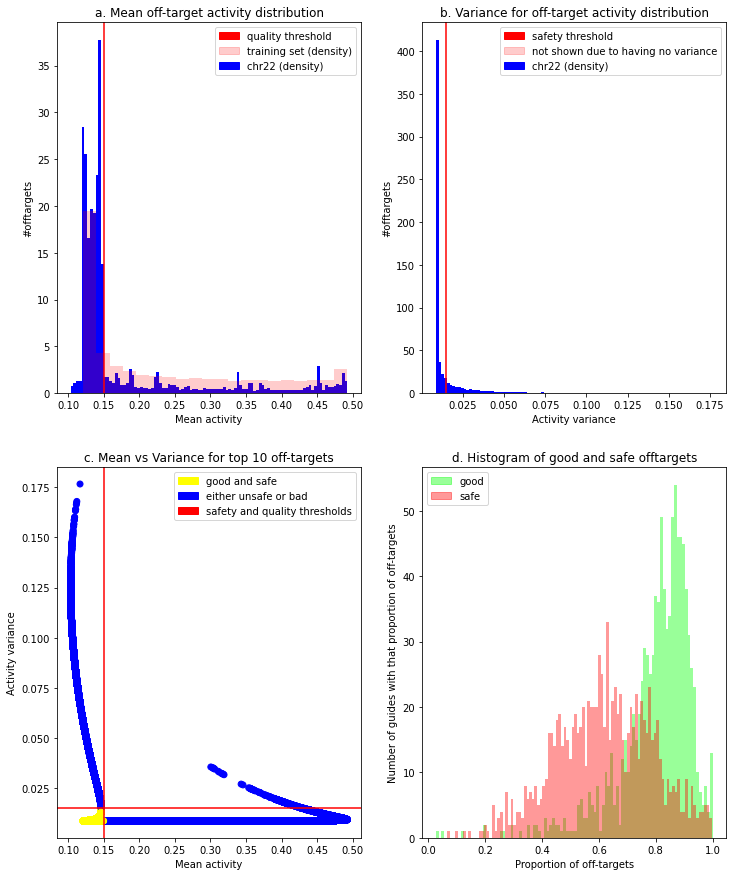

In [67]:
fig, ax = plt.subplots(2, 2)
#fig.suptitle('Off-targets for the best on-target gRNAs')
ax[0][0].hist(total[8].values, density=True, bins=100, color="blue")
ax[0][0].hist(ko_w_oa, bins=20, density=True, color=(1,0,0,0.2))
ax[0][0].axvline(0.15, color="red")
ax[0][0].legend(
    handles=[
        Patch(color="red", label="quality threshold"), 
        Patch(color=(1,0,0,0.2), label="training set (density)"),
        Patch(color="blue", label="chr22 (density)")
    ]
)
ax[0][0].set_title("a. Mean off-target activity distribution")
ax[0][0].set_xlabel("Mean activity")
ax[0][0].set_ylabel("#offtargets")
ax[0][1].hist(total[9].values, bins=100, density=True, color="blue")
ax[0][1].legend(
    handles=[
        Patch(color="red", label="safety threshold"), 
        Patch(color=(1,0,0,0.2), label="not shown due to having no variance"),
        Patch(color="blue", label="chr22 (density)")
    ]
)
ax[0][1].set_title("b. Variance for off-target activity distribution")
ax[0][1].set_xlabel("Activity variance")
ax[0][1].set_ylabel("#offtargets")
ax[0][1].axvline(0.015, color="red")
ax[1][0].scatter(
    total[8], total[9], 
    c=["yellow" if x else "blue" for x in np.logical_and(total[8] < 0.15, total[9] < 0.015)]
)
ax[1][0].legend(
    handles=[
        Patch(color="yellow", label="good and safe"), Patch(color="blue", label="either unsafe or bad"),
        Patch(color="red", label="safety and quality thresholds"), 
    ]
)
ax[1][0].set_title("c. Mean vs Variance for top 10 off-targets")
ax[1][0].set_xlabel("Mean activity")
ax[1][0].set_ylabel("Activity variance")
ax[1][0].axvline(0.15, color="red")
ax[1][0].axhline(0.015, color="red")
ax[1][1].hist(offtarget_statistics["good"], bins=100, color=(0,1,0,0.4))
ax[1][1].hist(offtarget_statistics["safe"], bins=100, color=(1,0,0,0.4))
ax[1][1].legend(
    handles=[Patch(color=(0,1,0,0.4), label="good"), Patch(color=(1,0,0,0.4), label="safe")]
)
ax[1][1].set_title("d. Histogram of good and safe offtargets")
ax[1][1].set_xlabel("Proportion of off-targets")
ax[1][1].set_ylabel("Number of guides with that proportion of off-targets")
fig.show()

In [48]:
np.arange(total.shape[0])[np.logical_and(total[8] < 0.15, total[9] < 0.015)].shape

(36926,)

In [64]:
total[[8,9]][np.logical_and(total[8] < 0.15, total[9] < 0.015)]

,8,9
4,0.145452,0.012006
5,0.145225,0.011772
6,0.145096,0.011720
7,0.143252,0.010751
8,0.142875,0.010619
...,...,...
61,0.121515,0.008753
62,0.121411,0.008757
63,0.121406,0.008750
64,0.121377,0.008761


In [68]:
np.mean(total[[8,9]][np.logical_and(total[8] < 0.15, total[9] < 0.015)][8])

0.13314853742489877

In [69]:
np.std(total[[8,9]][np.logical_and(total[8] < 0.15, total[9] < 0.015)][8])

0.008893503448181394

In [70]:
np.arange(total.shape[0])[np.logical_and(total[8] > 0.15, total[9] > 0.015)].shape

(794,)

In [81]:
total[np.logical_and(total[8] < 0.15, total[9] < 0.015)].shape[0]/total.shape[0]#good and safe

0.5480444610268708

In [82]:
total[total[8] < 0.15].shape[0]/total.shape[0]#good

0.7329186921778441

In [83]:
total[total[9] < 0.015].shape[0]/total.shape[0]#safe

0.814406727474263

In [74]:
total[np.logical_and(total[8] < 0.15, total[9] < 0.015)].shape

(605177, 12)

In [71]:
np.mean(total[8][np.logical_and(total[8] < 0.15, total[9] < 0.015)])

0.13314853742489877

In [72]:
np.mean(total[9][np.logical_and(total[8] < 0.15, total[9] < 0.015)])

0.009677301550762655

In [73]:
total.shape[0]

1104248

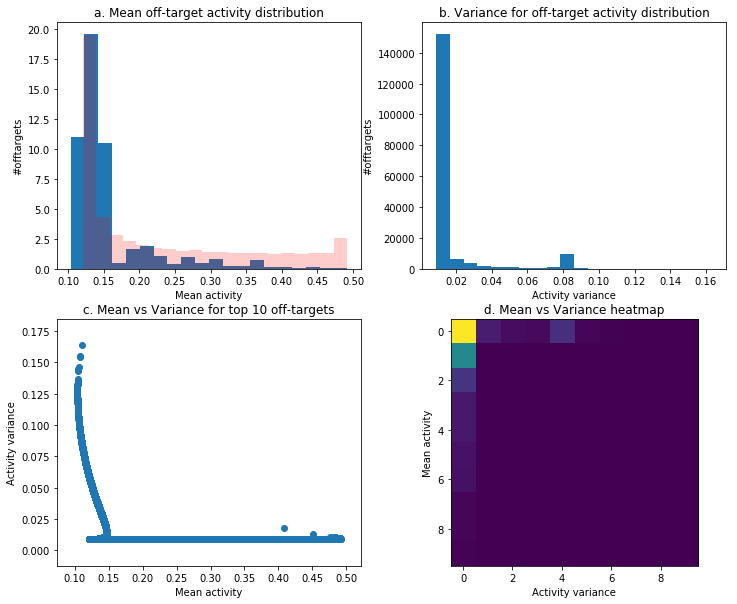

In [94]:
fig, ax = plt.subplots(2, 2)
#fig.suptitle('Off-targets for the best on-target gRNAs')
ax[0][0].hist(total[8].values, density=True, bins=20)
ax[0][0].hist(ko_w_oa, bins=20, density=True, color=(1,0,0,0.2))
ax[0][0].set_title("a. Mean off-target activity distribution")
ax[0][0].set_xlabel("Mean activity")
ax[0][0].set_ylabel("#offtargets")
ax[0][1].hist(total[9].values, bins=20)
#ax[0][1].hist(ko_w_va, bins=20, density=False, color=(1,0,0,0.2))
#ax[0][1].set_ylim((0,100))
ax[0][1].set_title("b. Variance for off-target activity distribution")
ax[0][1].set_xlabel("Activity variance")
ax[0][1].set_ylabel("#offtargets")
ax[1][0].scatter(total[8], total[9])
ax[1][0].set_title("c. Mean vs Variance for top 10 off-targets")
ax[1][0].set_xlabel("Mean activity")
ax[1][0].set_ylabel("Activity variance")
ax[1][1].imshow(pd.crosstab(total[10], total[11]).values)
ax[1][1].set_title("d. Mean vs Variance heatmap")
ax[1][1].set_xlabel("Activity variance")
ax[1][1].set_ylabel("Mean activity")
fig.show()

In [57]:
onehot([1,2,3])

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0])

In [89]:
len(pop[0])

46

In [94]:
u = correct_order(onehot(pop[0][0:23]))

In [96]:
u.shape

(92,)

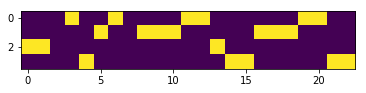

In [98]:
plt.imshow(u.reshape(4, 23))

In [101]:
np.stack([u.reshape(4, 23),u.reshape(4, 23)]).shape

(2, 4, 23)

In [91]:
len(pop[0][23:])

23

In [201]:
def active_and_uncertain(x):
    first = correct_order(onehot(x[0:23])).reshape(4, 23)
    second = correct_order(onehot(x[23:])).reshape(4, 23)
    x = torch.from_numpy(np.stack([first,second])).type(torch.FloatTensor)
    I = x.reshape(1, 2, 4, 23).cuda()
    tb_w = w_model(I)
    mlik = w_model.likelihood(
        tb_w[0]
    )
    tb_w_o = mlik.mean.mean(0).cpu().data.numpy()
    tb_w_v = mlik.variance.mean(0).cpu().data.numpy()**0.5
    mm = sum([int(d==e) for d,e in zip(x[0:23],x[23:])])/23
    return(tb_w_o+0.5*tb_w_v+mm)

In [202]:
from deap import algorithms

In [203]:
import random
from deap import base, creator, tools, algorithms

def evaluate(individual):
    return(active_and_uncertain(individual))

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("nucleotide", random.randint, 1, 4)
toolbox.register(
    "individual", tools.initRepeat, creator.Individual, 
    toolbox.nucleotide, 2*23
)
toolbox.register(
    "population", tools.initRepeat, list, toolbox.individual
)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=1, up=4, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [204]:
pop = toolbox.population(n=3000)
hof = tools.HallOfFame(100)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [205]:
pop, log = algorithms.eaSimple(
    pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, 
    stats=stats, halloffame=hof, verbose=True
)

KeyboardInterrupt: 

In [169]:
np.array(pop)[0]

array([4, 2, 2, 1, 2, 4, 4, 4, 4, 4, 4, 1, 1, 2, 2, 3, 4, 4, 4, 1, 2, 2,
       2, 1, 1, 3, 3, 2, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 4, 1, 2, 3, 3, 3,
       4, 4])

In [170]:
first_t = correct_order(onehot(hof[0][0:23])).reshape(4,23)
second_t = correct_order(onehot(hof[0][23:])).reshape(4,23)

In [148]:
def from_oh(x):
    onehot2nucleotide = {
        1: "A", 2: "T", 3: "G", 4: "C"
    }
    return("".join([onehot2nucleotide[a] for a in x]))

In [149]:
len(hof)

100

In [191]:
def n_mms(a):
    b = a[0:23]
    c = a[23:]
    return(sum([int(d==e) for d,e in zip(b,c)]))

In [174]:
np.unique([n_mms(a) for a in pop], return_counts=True)

(array([18, 19, 20, 21, 22, 23]), array([   1,    7,   35,  187, 2732,   38]))

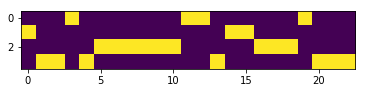

In [175]:
plt.imshow(first_t)

In [177]:
np.stack([first_t, second_t])

(2, 4, 23)

In [180]:
w_f = w_model(
    torch.from_numpy(np.stack([first_t, second_t]).reshape(1, 2, 4, 23)).cuda()
)

In [193]:
n_mms(hof[0])/23

0.043478260869565216

In [197]:
w_o = w_model.likelihood(w_f[0]).mean.mean(0).cpu().data.numpy()
w_v = w_model.likelihood(w_f[0]).variance.mean(0).cpu().data.numpy()**0.5

In [198]:
w_v

array([0.47571176], dtype=float32)

In [199]:
w_v+w_o+n_mms(hof[0])/23

array([0.7504903], dtype=float32)

In [200]:
w_o

array([0.23130026], dtype=float32)

In [171]:
from_oh(hof[0][0:23]), from_oh(hof[0][23:])

('GTTATCCCCCCAATGGCCCATTT', 'AAGGTGGAGGGGCGCAATGGGCC')

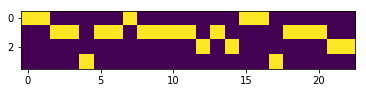

In [173]:
plt.imshow(second_t)